In [19]:
import torch as tn
import torchtt as tntt
import matplotlib.pyplot as plt
import tt_iga
import iga_fem
import numpy as np
import datetime
import matplotlib.colors
import scipy.sparse.linalg 
import pandas as pd
import os
import datetime
import multiprocessing as mp
import fenics as fn
import pickle

tn.set_default_dtype(tn.float64)

Define function and classes for the Fenics solver

In [20]:

def create_file_and_mesh(theta,meshsize = 0.5, verb = False):
    
    with open('fem_mesh/cylinder_material1_proto.geo', 'r') as file:
        data = file.read()
        
    s = "theta2 = %.18f; \ntheta3 = %.18f; \ntheta4 = %.18f;\nmeshsize=%.18f;"%(theta[1],theta[2],theta[3],meshsize)
    
    s = s + data
    
    with  open("fem_mesh/tmp.geo", "w") as file:
        file.write(s)
        file.close()
    if verb: print('geo file created',flush = True)
    
    if verb:
        os.system('gmsh fem_mesh/tmp.geo -nt 20 -3 -o fem_mesh/tmp.msh -format msh2 ')
    else:
        os.system('gmsh fem_mesh/tmp.geo -nt 20 -3 -o fem_mesh/tmp.msh -format msh2 >/dev/null 2>&1')
    if verb: print('mesh file created',flush=True)

    if verb:
        os.system('dolfin-convert fem_mesh/tmp.msh fem_mesh/tmp.xml')
    else:
        os.system('dolfin-convert fem_mesh/tmp.msh fem_mesh/tmp.xml >/dev/null 2>&1')
    
    if verb: print('mesh file converted in fenics format',flush=True) 

    mesh = fn.Mesh('fem_mesh/tmp.xml')
    markers = fn.MeshFunction("size_t", mesh, 'fem_mesh/tmp_physical_region.xml')
    boundaries = fn.MeshFunction('size_t', mesh, 'fem_mesh/tmp_facet_region.xml')
    if verb: print('mesh imported')

    return mesh, markers, boundaries

class Solver():
    
    def __init__(self):
        pass
    
    def set_params(self, theta, meshsize=0.4):
        '''
        Set the parameters.

        Parameters
        ----------
        theta : list of floats or numpy array
            The parameters. Belong to [-0.05,0.05].
        meshsize : float, optional
            The meshgrid size. The default is 0.4.

        Returns
        -------
        None.

        '''
        self.theta = theta
        self.meshsize = meshsize
        
    def create_mesh(self, verb = False):
        '''
        Create the mesh and save it 

        Returns
        -------
        tme : datetime object
            Duration of simulation.

        '''
        if verb: print('meshsize ',self.meshsize,' thetas ',self.theta,flush=True)
        tme = datetime.datetime.now()
        mesh, subdomains, boundaries = create_file_and_mesh(self.theta, self.meshsize, verb)
        self.mesh = mesh
        self.subdomains = subdomains
        self.boundaries = boundaries
        tme = datetime.datetime.now() - tme
        if verb : print('Time needed for meshing and importing ',tme,flush=True)

        return tme
        
    def solve(self, verb = False):
        '''
        Solve the problem

        Returns
        -------
        tme : datetime object
            Duration of simulation.

        '''
        tme = datetime.datetime.now()
    
        class permittivity(fn.UserExpression):
            def __init__(self, markers, val, **kwargs):
                self.markers = markers
                self.val = val
                super().__init__(**kwargs)
            
            def eval_cell(self, values, x, cell):
                if self.markers[cell.index] == 44:
                    values[0] = self.val
                else:
                    values[0] = 1
    
        kappa = permittivity(self.subdomains, 6.0+self.theta[0]*5.0, degree=2)
                
        
        
        dx = fn.Measure('dx', domain=self.mesh, subdomain_data=self.subdomains)
        V = fn.FunctionSpace(self.mesh, 'CG', 2)
        
        
    
        top_boundary = fn.DirichletBC(V, fn.Constant(0.0), self.boundaries, 41)
        bottom_boundary = fn.DirichletBC(V, fn.Constant(10.0), self.boundaries, 42)
        # mantle_boundary = fn.DirichletBC(V, fn.Constant(1), boundaries, 43)
        bcs =[top_boundary, bottom_boundary]
        
        # Solve the Poisson equation with the source set to 0
        u = fn.TrialFunction(V)
        v = fn.TestFunction(V)
        a = fn.dot(fn.grad(u), fn.grad(v)) * (kappa) * fn.dx
        L = fn.Constant('0') * v * fn.dx
        u = fn.Function(V)
        if verb: print('solving...',flush=True)
        # fn.solve(a == L, u, bcs, solver_parameters={str('linear_solver'): str('gmres'), 'relative_tolerance' : 1e-8})
        problem = fn.LinearVariationalProblem(a, L, u, bcs)
        solver = fn.LinearVariationalSolver(problem)

        solver.parameters['linear_solver'] = 'gmres'
        solver.parameters['preconditioner'] = 'ilu'
        prm = solver.parameters['krylov_solver'] 
        prm['absolute_tolerance'] = 1E-10
        prm['relative_tolerance'] = 1E-6
        prm['maximum_iterations'] = 1000    
        solver.solve()
        if verb: print('system solved',flush=True)
        #problem = fn.LinearVariationalProblem(a, L, u, bcs)
        #solver = fn.LinearVariationalSolver(problem)
        # fn.solve(a == L, u, bcs)
    
        self.u = u
        
        tme = datetime.datetime.now() - tme
        return tme
        
    def get_dof_vector(self):
        '''
        Returns the DoF vector of the solution.

        Returns
        -------
        numpy array
            the DoF vector.

        '''

        return self.u.vector()

    def get_dof_size(self):
        '''
        Returns the size of the DoF vector.

        Returns
        -------
        int
            the size of the DoF vector.

        '''

        return self.u.vector()[:].size

    def __call__(self, x1s, x2s, x3s):
        '''
        Evaluates the solution.

        Parameters
        ----------
        x1s : numpy array
            first coordinates.
        x2s : numpy array
            second coordinates.
        x3s : numpy array
            third coordinates.

        Returns
        -------
        numpy array
            the solution evaluated on the given points.

        '''
        shape = x1s.shape
    
        x1s = x1s.flatten()
        x2s = x2s.flatten()
        x3s = x3s.flatten()
        
        ucalc = 0*x1s
    
        for i in range(x1s.size):
            try:
                ucalc[i] = self.u((x1s[i],x2s[i],x3s[i]))
            except:
                ucalc[i] = np.nan    
        return ucalc.reshape(shape)

def aux_fun(dct_results_iga,i,ms,queue):
    
    degs = dct_results_iga['degs']
    ns = dct_results_iga['ns']
    nls = dct_results_iga['nls']
   
    nl = nls[1]
    
    print()
    print(' i = %d/%d, ms = %f'%(i,dct_results_iga['params'].shape[0],ms))
    print()

    solver = Solver()
    solver.set_params(dct_results_iga['params'][i,:], ms)
    solver.create_mesh(False)
    solver.solve(False)
    
    errz_tmp = []
    
    for n in ns:
        x = dct_results_iga['results'][(degs[0],n,nl)]['computations'][i]['xs']
        y = dct_results_iga['results'][(degs[0],n,nl)]['computations'][i]['ys']
        z = dct_results_iga['results'][(degs[0],n,nl)]['computations'][i]['zs']
        fval = dct_results_iga['results'][(degs[0],n,nl)]['computations'][i]['us']
        ws = dct_results_iga['results'][(degs[0],n,nl)]['computations'][i]['ws']
        femval = solver(x,y,z)
        
        err = np.sqrt(np.nansum((fval-femval)**2*ws))
        print(err)
        errz_tmp.append(err)
    del solver.u
    del solver                  
    queue.put(errz_tmp)


In [21]:
deg = 2
Ns = np.array([80,80,80])-deg+1
baza1 = tt_iga.BSplineBasis(np.concatenate((np.linspace(0,0.5,Ns[0]//2),np.linspace(0.5,1,Ns[0]//2))),deg)
baza2 = tt_iga.BSplineBasis(np.linspace(0,1,Ns[1]),deg)
baza3 = tt_iga.BSplineBasis(np.concatenate((np.linspace(0,0.3,Ns[2]//3),np.linspace(0.3,0.7,Ns[2]//3),np.linspace(0.7,1,Ns[2]//3))),deg)

Basis = [baza1,baza2,baza3]
N = [baza1.N,baza2.N,baza3.N]
print(N)

nl = 12
Basis_param = [tt_iga.LagrangeLeg(nl,[-0.05,0.05])]*4

[79, 80, 79]


In [22]:
# square to circle transformation
xc = lambda u,v: u*tn.sqrt(1-v**2/2)
yc = lambda u,v: v*tn.sqrt(1-u**2/2)
# scale [0,1] to an inteval [a,b]
line = lambda t,a,b: t*(b-a)+a
# aux function needed for mapping along the length of the cylinder
def scaling(z,theta1,theta2):
    a = 0.3
    b = 0.7
    s = (z<a)*line(z/a,0,a+theta1)
    s+= tn.logical_and(z>=a,z<=b)*line((z-a)/(b-a),a+theta1,b+theta2)
    s+= tn.logical_and(z>b,z<=1)*line((z-b)/(1-b),b+theta2,1)
    return s

# create the components of the parametrization
angle_mult = 1.0
xparam = lambda t : xc(t[:,0]*2-1,t[:,1]*2-1)
yparam = lambda t : yc(t[:,0]*2-1,t[:,1]*2-1)
zparam = lambda t : scaling(t[:,2],t[:,6],t[:,5]+xparam(t)*angle_mult*t[:,4]+yparam(t)*0*t[:,4])
# create the material coeffiecient (defined on the reference domain)
sigma_ref = lambda x:  0.0*x[:,2]+(5.0+x[:,3]*5.0)*tn.logical_and(x[:,0]>=0.0,x[:,0]<0.5)*tn.logical_and(x[:,2]>0.3,x[:,2]<0.7)+1

#%% Instantiate the Geometry object and do some plots
geom = tt_iga.Geometry(Basis+Basis_param)
geom.interpolate([xparam, yparam, zparam])

In [23]:
tme = datetime.datetime.now() 
Mass_tt = geom.mass_interp(eps=1e-11)
tme = datetime.datetime.now() -tme
print('Time mass matrix ',tme.total_seconds())

tme = datetime.datetime.now() 
Stt = geom.stiffness_interp( func=None, func_reference = sigma_ref, qtt = False, verb=False)
tme = datetime.datetime.now() -tme
print('Time stiffness matrix ',tme.total_seconds())

f_tt = tntt.zeros(Stt.N)

# incorporate the boundary conditions and construct the system tensor operator
Pin_tt,Pbd_tt = tt_iga.get_projectors(N,[[1,1],[1,1],[0,0]])
# Pbd_tt = (1/N[0]) * Pbd_tt
U0 = 10

Pin_tt = Pin_tt ** tntt.eye([nl]*4)
Pbd_tt = Pbd_tt ** tntt.eye([nl]*4)


tmp = tn.zeros(N, dtype = tn.float64)
tmp[:,:,0] = U0 

g_tt = Pbd_tt @ (tntt.TT(tmp) ** tntt.ones([nl]*4))


M_tt = Pin_tt@Stt@Pin_tt + Pbd_tt
rhs_tt = Pin_tt @ (Mass_tt @ f_tt - Stt@Pbd_tt@g_tt).round(1e-12) + g_tt
M_tt = M_tt.round(1e-9)

Time mass matrix  0.058955
Time stiffness matrix  22.175979


In [24]:
eps_solver = 1e-6

print('Solving in TT...')
tme_amen = datetime.datetime.now() 
dofs_tt = tntt.solvers.amen_solve(M_tt.cuda(), rhs_tt.cuda(), x0 = tntt.ones(rhs_tt.N).cuda(), eps = eps_solver, nswp=40, kickrank=4).cpu()
tme_amen = (datetime.datetime.now() -tme_amen).total_seconds() 
print('Time system solve in TT ',tme_amen)

Solving in TT...
Time system solve in TT  33.894454


FEM solution for the problem

In [25]:
params = [0.05, 0.05, 0.05, 0.05]
solver_fine = Solver()
solver_fine.set_params(params, 0.08)
tme_mesh_fem = solver_fine.create_mesh(False)
tme_solve_fem = solver_fine.solve(False)


Solving linear variational problem.


Building point search tree to accelerate distance queries.
Computed bounding box tree with 780797 nodes for 390399 points.


Text(0.5, 0, '$x_3$')

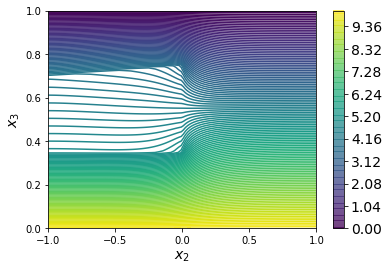

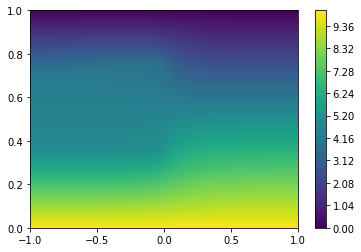

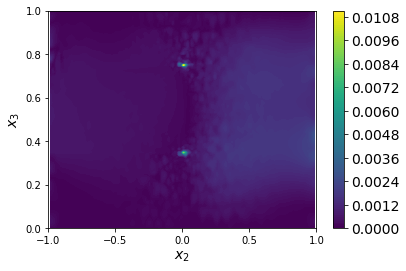

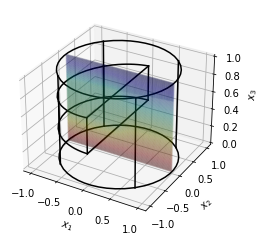

In [26]:
fspace = tt_iga.Function(Basis+Basis_param)
fspace.dofs = dofs_tt

fval = fspace([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05])])
x,y,z = geom([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05])])

plt.figure()
plt.contour(x.full().numpy().squeeze(),z.full().numpy().squeeze(),fval.full().numpy().squeeze(), levels = 128)
plt.xlabel(r'$x_2$', fontsize=14)
plt.ylabel(r'$x_3$', fontsize=14)
fig.gca().tick_params(axis='both', labelsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.savefig('./data/jump_solution.pdf')

plt.figure()
plt.contourf(x.full().numpy().squeeze(),z.full().numpy().squeeze(),fval.full().numpy().squeeze(), levels = 128)
plt.colorbar()

ufem = solver_fine(x.full().numpy().squeeze(),y.full().numpy().squeeze(),z.full().numpy().squeeze())

plt.figure()
plt.contourf(x.full().numpy().squeeze(),z.full().numpy().squeeze(),np.abs(fval.full().numpy().squeeze()-ufem), levels = 128)
plt.xlabel(r'$x_2$', fontsize=14)
plt.ylabel(r'$x_3$', fontsize=14)
fig.gca().tick_params(axis='both', labelsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.savefig('./data/jump_error.pdf')
                    
from matplotlib import cm
fig = geom.plot_domain([tn.tensor([0.05])]*4,[(0,1),(0,1),(0.0,1)],surface_color=None, wireframe = False,frame_color='k')
geom.plot_domain([tn.tensor([0.05])]*4,[(0.0,0.5),(0.0,1),(0.3,0.7)],fig = fig,surface_color=None,wireframe = False,frame_color='k')

ax = fig.gca()
C = fval.full().numpy().squeeze()
norm = matplotlib.colors.Normalize(vmin=C.min(),vmax=C.max())
C = plt.cm.jet(norm(C))
C[:,:,-1] = 1
ax.plot_surface(x.full().numpy().squeeze(),y.full().numpy().squeeze(),z.full().numpy().squeeze(),facecolors = C, antialiased=True,rcount=256,ccount=256,alpha=0.1)

fig.gca().set_xlabel(r'$x_1$')
fig.gca().set_ylabel(r'$x_2$')
fig.gca().set_zlabel(r'$x_3$')

# fig = plt.figure(figsize = (14, 9))
# ax = plt.axes(projection = '3d')
# ax.plot_surface(x.full().squeeze(), z.full().squeeze(), fval.full().squeeze(), facecolors = C)



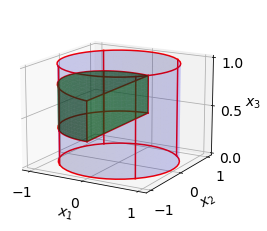

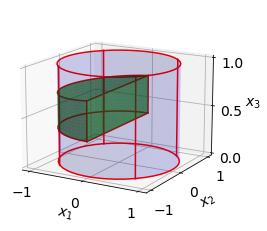

In [27]:
fig = geom.plot_domain([tn.tensor([0.05]),tn.tensor([-0.05]),tn.tensor([0.05]),tn.tensor([0.05])],[(0,1),(0,1),(0.0,1)],surface_color='blue', wireframe = False,alpha=0.1)
geom.plot_domain([tn.tensor([0.05]),tn.tensor([-0.05]),tn.tensor([0.05]),tn.tensor([0.05])],[(0.0,0.5),(0.0,1),(0.3,0.7)],fig = fig,surface_color='green',wireframe = False)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xlabel(r'$x_1$', fontsize=14)
fig.gca().set_ylabel(r'$x_2$', fontsize=14)
fig.gca().set_zlabel(r'$x_3$', fontsize=14)
fig.gca().set_xticks([-1, 0, 1])
fig.gca().set_yticks([-1, 0, 1])
fig.gca().set_zticks([0, 0.5, 1])
fig.gca().view_init(15, -60)
fig.gca().tick_params(axis='both', labelsize=14)
plt.savefig('./data/cylinder_material1.pdf')

fig = geom.plot_domain([tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05])],[(0,1),(0,1),(0.0,1)],surface_color='blue', wireframe = False,alpha=0.1)
geom.plot_domain([tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05]),tn.tensor([0.05])],[(0.0,0.5),(0.0,1),(0.3,0.7)],fig = fig,surface_color='green',wireframe = False)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xlabel(r'$x_1$', fontsize=14)
fig.gca().set_ylabel(r'$x_2$', fontsize=14)
fig.gca().set_zlabel(r'$x_3$', fontsize=14)
fig.gca().set_xticks([-1, 0, 1])
fig.gca().set_yticks([-1, 0, 1])
fig.gca().set_zticks([0, 0.5, 1])
fig.gca().view_init(15, -60)
fig.gca().tick_params(axis='both', labelsize=14)
plt.savefig('./data/cylinder_material2.pdf')